# Prediction Modeling

- 데이터분석을 실시했던 Kaggle의 Hotel booking 데이터로 예측모델링 실시

## 배경

- 현재 마케팅부서에서 호텔 예약 건수를 늘리기 위한 추가적인 마케팅 전략을 수립하려고 함. 새로운 마케팅전략에 근간이 되는 인사이트를 데이터로부터 도출 요청.

- 데이터분석 리포팅에서 설정했던 '예약 취소하는 사람들의 특성' 가설을 기반으로 데이터에서 호텔을 예약하는 사람들의 여러가지 특징(feature)들로 이 사람의 예약 취소 여부(binary)를 예측하는 모델을 구현하려 함.

## 목적

- 호텔을 최초로 예약할 때의 특징들을 독립변수들로 하여 추후 예약 취소 여부를 예측
- 취소로 예측된 예약들의 공통된 특성을 파악하고 이를 마케팅 부서에게 전달

## 가설

- 사전에 실시한 데이터 분석으로 보증금 유형이 Non-Refund이면서 market_segment가 Groups나 Offline TA/TO일 때 예약 취소 가능성이 높았음을 도출. 따라서 deposit_type과 market_segment가 여러 중요한 변수 중 일부일 것이라고 판단


## 데이터 전처리

In [60]:
# 데이터로드
import pandas as pd
import numpy as np
import os
os.chdir('/Users/younghun/Desktop/gitrepo/data')
hotel = pd.read_csv('hotel_bookings.csv', encoding='utf-8')
hotel.shape

(119390, 32)

- 결측치가 있는 변수들
    * agent : 예약을 대행한 여행업체의 ID
    * company : 예약을 한 기업의 ID(익명화 처리됨)
    * country : 예약한 투숙객의 국적
    * children : 예약한 투숙객의 아이들 수
- 하지만 결측치가 있는 변수들 중 agent, company, country는 우리가 설정한 문제를 해결하는 데 유용하지 않은 변수이다.
- children은 결측치가 4개 이므로 해당 결측치를 0으로 대체해도 무방

### 종속변수에 대한 이해

In [61]:
hotel['is_canceled'].value_counts()

0    75166
1    44224
Name: is_canceled, dtype: int64

In [62]:
(75166) / (75166+44224)

0.6295837172292487

In [63]:
(44224) / (75166+44224)

0.37041628277075134

In [64]:
# data type을 보고 int, float형으로 되어있어야하는 변수 type이 object로 되어있다면 ' '와 같은 공백 문자열이 결측치로 들어가 있을 가능성 체크
hotel.dtypes

hotel                              object
is_canceled                         int64
lead_time                           int64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                              int64
children                          float64
babies                              int64
meal                               object
country                            object
market_segment                     object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
assigned_room_type                 object
booking_changes                     int64
deposit_type                       object
agent                             

In [65]:
# 의심가는 변수 : arrival_date_month 확인해보자 -> month가 문자열로 되어있음 
hotel['arrival_date_month'].unique()

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

In [66]:
# 문자열 month를 숫자형으로 mapping
month_dict = {'July':7, 'August':8, 'September':9, 'October':10, 'November':11, 'December':12,
             'January':1, 'February':2, 'March':3, 'April':4, 'May':5, 'June':6}
hotel['arrival_date_month'] = hotel['arrival_date_month'].map(month_dict)
hotel['arrival_date_month'].unique()

array([ 7,  8,  9, 10, 11, 12,  1,  2,  3,  4,  5,  6])

In [67]:
# 이상치 처리하기
# 수치형 변수들 기초통계량 살펴보기(날짜관련 변수, 취소여부 변수 제외)
numeric_cols = pd.Series(hotel.dtypes[hotel.dtypes != 'object'].index)
numeric_cols = numeric_cols[~numeric_cols.str.contains('date|nights')].values
numeric_cols = numeric_cols.tolist()
numeric_cols.remove('adr')
print(numeric_cols)

['is_canceled', 'lead_time', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests']


In [68]:
# 추출한 변수들로 기초통계량 살펴보기
hotel[numeric_cols].describe()

,is_canceled,lead_time,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,103050.000000,6797.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,1.856403,0.103890,0.007949,0.031912,0.087118,0.137097,0.221124,86.693382,189.266735,2.321149,0.062518,0.571363
std,0.482918,106.863097,0.579261,0.398561,0.097436,0.175767,0.844336,1.497437,0.652306,110.774548,131.655015,17.594721,0.245291,0.792798
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,6.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000,62.000000,0.000000,0.000000,0.000000
50%,0.000000,69.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,179.000000,0.000000,0.000000,0.000000
75%,1.000000,160.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,229.000000,270.000000,0.000000,0.000000,1.000000
max,1.000000,737.000000,55.000000,10.000000,10.000000,1.000000,26.000000,72.000000,21.000000,535.000000,543.000000,391.000000,8.000000,5.000000


- adr : 숙박 예약의 총 합을 숙박 일수의 총 합으로 나눈 일일 비율로 예측모델링에는 필요하지 않은 변수로 예상되어 이상치 탐지 안 함.
-  lead_time, adults, days_in_waiting_list 이렇게 3개의 변수가 이상치가 있는 것으로 판단이 되지만 무조건적으로 제거하면 안 됨.
-  이상치들의 정확한 존재 이유를 파악하고 제거를 하거나 유지하고 scaling을 해줄지 결정해야 함

### numeric 독립변수들과 취소여부인 종속변수와의 상관관계 살펴보기

Text(0.5, 1.0, 'Pearson Correlation of numeric variables and target variable')

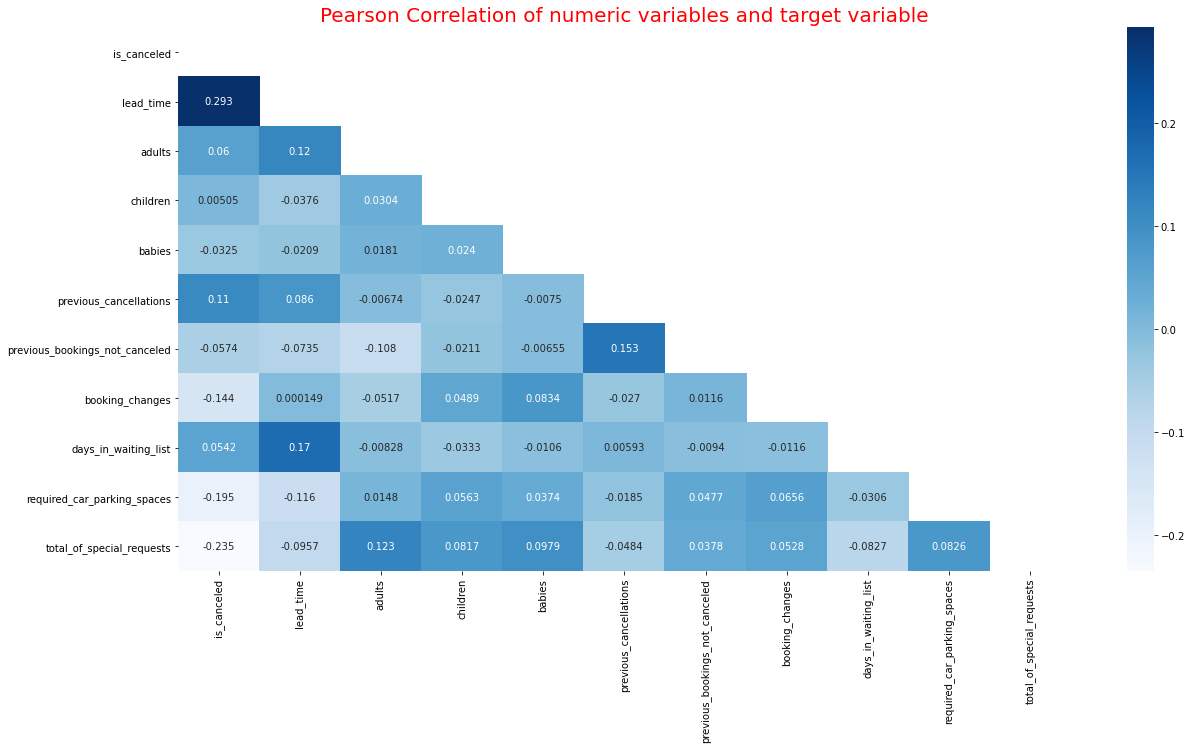

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns
num_cols = ['is_canceled','lead_time','adults','children','babies',
           'previous_cancellations','previous_bookings_not_canceled','booking_changes',
           'days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']
numeric_df = hotel[num_cols]
corr = numeric_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(20,10))
sns.heatmap(corr, mask=mask, cmap='Blues', annot=True, fmt='.3g')
plt.title('Pearson Correlation of numeric variables and target variable', fontsize=20, color='red')


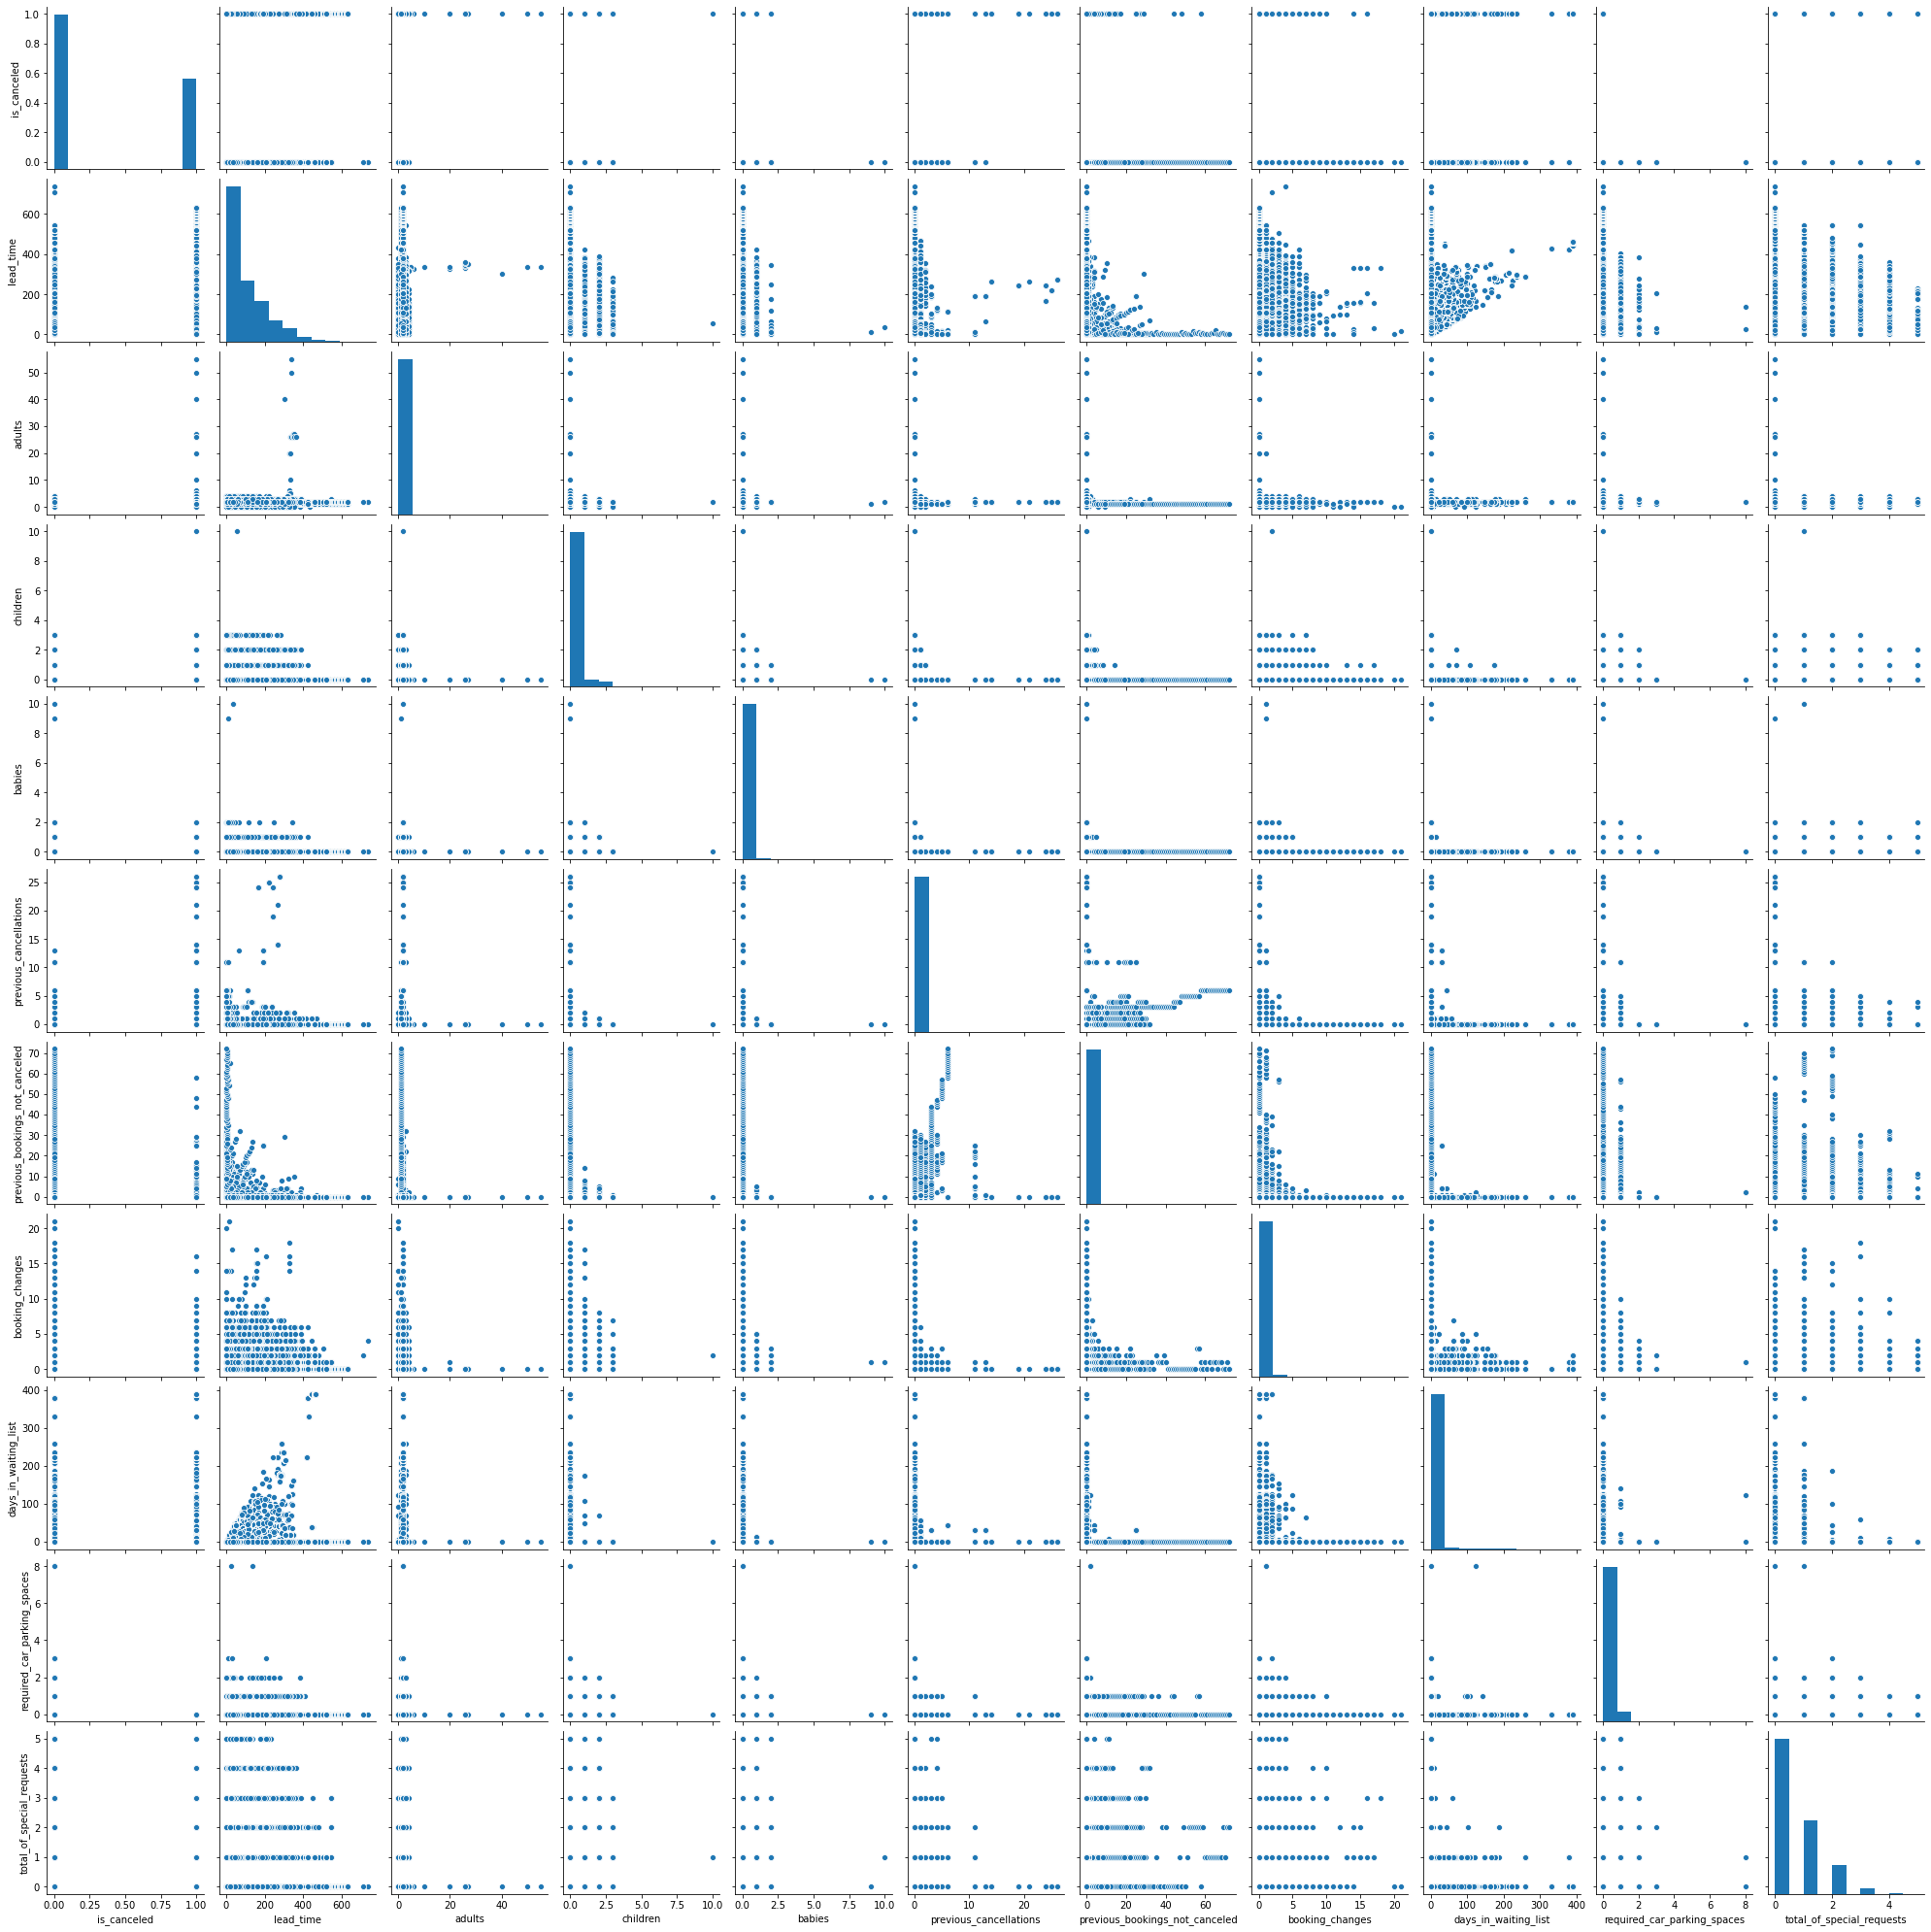

In [59]:
# 수치형 변수들과 종속변수 끼리 scatterplot 그려보기
sns.pairplot(data=numeric_df)

- 산점도를 관찰한 결과 다중공산성이 있을 것 같은 변수 후보 추출
    * lead_time 과 days_in_waiting_list, booking_changes
- VIF(분산팽창요인)를 통해 VIF값 10이 넘는지 확인
    * VIF 5이상 10미만이면 다중공산성 주의 요망
    * VIF 10이상이면 다중공산성으로 판단

In [125]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
df = hotel[['is_canceled','lead_time','days_in_waiting_list','booking_changes']]

# 회귀식 정의해주기 (R문법이랑 비슷))
y, X = dmatrices('is_canceled ~ lead_time + days_in_waiting_list + booking_changes', df, return_type='dataframe')

vif = pd.DataFrame()
# 변수 하나씩 반복문돌면서 Values array 형태에서 해당 변수값에 해당하는 VIF값 뽑아내기
vif['VIF Factor'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['Features'] = X.columns
vif

,VIF Factor,Features
0,2.063072,Intercept
1,1.029795,lead_time
2,1.029935,days_in_waiting_list
3,1.000140,booking_changes


- 다중공산성이 존재하려면 VIF값이 10이 넘는 변수들끼리 다중공산성 존재 의미
- 하지만 VIF값 10이 넘는 변수들은 존재하지 않음
- 따라서 다중공산성 존재하지 않음

### lead_time 변수

In [71]:
# lead_time 이상치 파악
# lead_time 값의 종류들 살펴보기 -> 의외로 몇백일 단위의 값들이 많다.. 이상치 제거할 필요보단 정규화시켜주어야 할 듯 싶다.
hotel['lead_time'].unique()

array([342, 737,   7,  13,  14,   0,   9,  85,  75,  23,  35,  68,  18,
        37,  12,  72, 127,  78,  48,  60,  77,  99, 118,  95,  96,  69,
        45,  40,  15,  36,  43,  70,  16, 107,  47, 113,  90,  50,  93,
        76,   3,   1,  10,   5,  17,  51,  71,  63,  62, 101,   2,  81,
       368, 364, 324,  79,  21, 109, 102,   4,  98,  92,  26,  73, 115,
        86,  52,  29,  30,  33,  32,   8, 100,  44,  80,  97,  64,  39,
        34,  27,  82,  94, 110, 111,  84,  66, 104,  28, 258, 112,  65,
        67,  55,  88,  54, 292,  83, 105, 280, 394,  24, 103, 366, 249,
        22,  91,  11, 108, 106,  31,  87,  41, 304, 117,  59,  53,  58,
       116,  42, 321,  38,  56,  49, 317,   6,  57,  19,  25, 315, 123,
        46,  89,  61, 312, 299, 130,  74, 298, 119,  20, 286, 136, 129,
       124, 327, 131, 460, 140, 114, 139, 122, 137, 126, 120, 128, 135,
       150, 143, 151, 132, 125, 157, 147, 138, 156, 164, 346, 159, 160,
       161, 333, 381, 149, 154, 297, 163, 314, 155, 323, 340, 35

<AxesSubplot:>

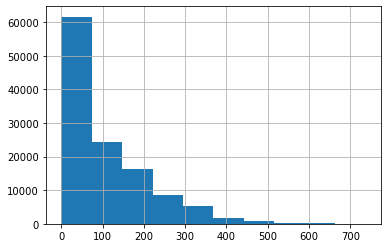

In [72]:
# 값들 분포 확인하기
hotel['lead_time'].hist()

<AxesSubplot:>

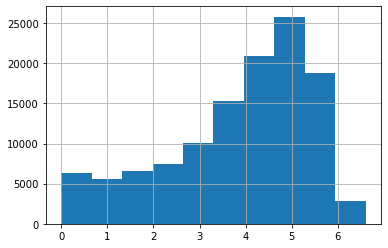

In [73]:
# +1한다음 log를 이용해 정규분포화시키기
np.log1p(hotel['lead_time']).hist()

- lead_time 은 log1p를 이용해서 분포를 변환해주자

### adults, children, babies 변수

- 기본적으로 위 3가지 변수는 종속변수(취소여부)와 상관계수가 매우 낮다. 
    * adults : 0.06
    * children : 0.00504
    * babies : -0.03
- 따라서 위 3가지 변수와 예약취소여부와의 관계는 선형관계가 아니다.

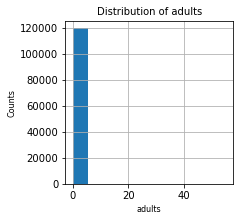

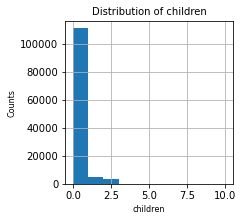

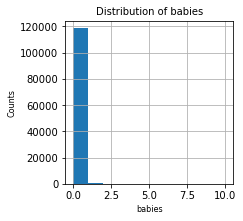

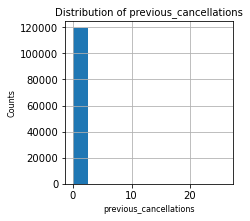

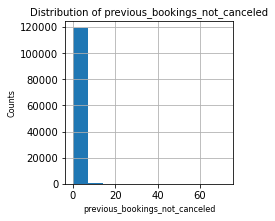

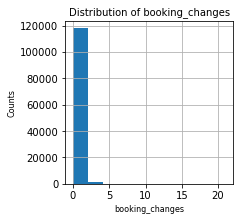

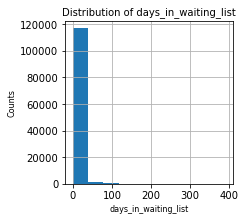

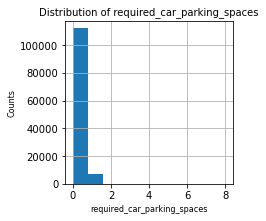

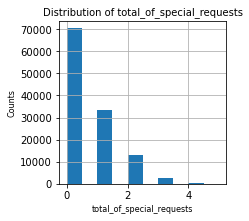

In [74]:
hist_cols = ['adults','children','babies','previous_cancellations','previous_bookings_not_canceled',
             'booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']
for col in hist_cols:
    plt.figure(figsize=(3,3))
    hotel[col].hist()
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel(col, fontsize=8)
    plt.ylabel('Counts', fontsize=8)

In [75]:
# adult변수 원본 분포형태 보기
hotel['adults'].value_counts()

2     89680
1     23027
3      6202
0       403
4        62
26        5
27        2
20        2
5         2
55        1
50        1
40        1
10        1
6         1
Name: adults, dtype: int64

<AxesSubplot:>

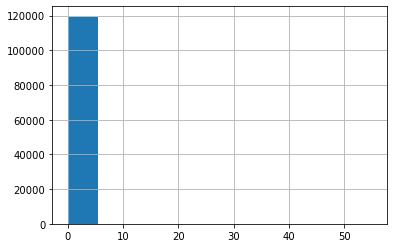

In [76]:
hotel['adults'].hist()

0.0     110796
1.0       4861
2.0       3652
3.0         76
10.0         1
Name: children, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


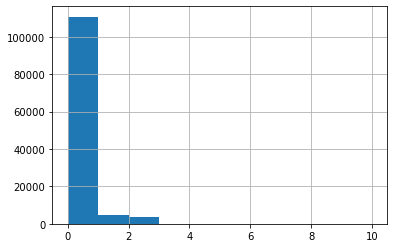

In [77]:
# children 변수
print(hotel['children'].value_counts())
print(hotel['children'].hist())

0     118473
1        900
2         15
10         1
9          1
Name: babies, dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


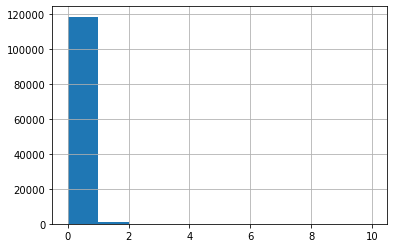

In [78]:
# babies 변수
print(hotel['babies'].value_counts())
print(hotel['babies'].hist())

- **종속변수와 선형관계를 보이지 않을 뿐더러 독립변수 값들의 분포가 한 값에 매우 몰려있기 때문에 해당 변수들을 예측 모델의 feature로서는 적합하지 않다고 판단**

### previous_cancellations

<AxesSubplot:>

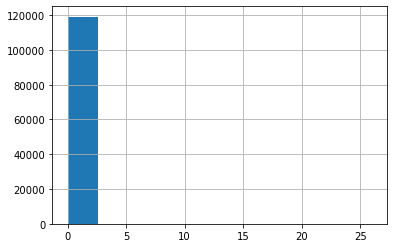

In [79]:
hotel['previous_cancellations'].hist()

In [80]:
hotel['previous_cancellations'].value_counts()

0     112906
1       6051
2        116
3         65
24        48
11        35
4         31
26        26
25        25
6         22
19        19
5         19
14        14
13        12
21         1
Name: previous_cancellations, dtype: int64

In [81]:
# 이상치라고 판단되는 value가 7이상인 데이터들은 예약을 모두 취소한 건수들일까?
hotel.loc[hotel['previous_cancellations'] > 6, 'is_canceled'].value_counts()

1    154
0     26
Name: is_canceled, dtype: int64

- 종속변수와의 상관계수값은 0.11이다.
- 이상치로 판단되는 값들의 예약취소여부를 조사해보니 그래도 이상치에 해당하는 값들이 예약 취소건수가 많았다. 따라서 이상치를 제거할 순 없다고 판단.
- 이상치가 있긴 하지만 제거하지 않고 이상치에 민감하지 않는 Robust scaler를 사용하자.

### previous_bookings_not_canceled

<AxesSubplot:>

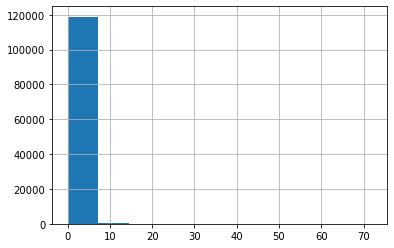

In [82]:
hotel['previous_bookings_not_canceled'].hist()

In [83]:
pd.options.display.max_rows=200
hotel['previous_bookings_not_canceled'].value_counts()

0     115770
1       1542
2        580
3        333
4        229
5        181
6        115
7         88
8         70
9         60
10        53
11        43
12        37
13        30
14        28
15        21
16        20
25        17
17        16
18        14
19        13
20        12
21        12
22        10
24         9
27         9
23         7
26         7
28         7
29         6
30         4
44         2
48         2
31         2
32         2
58         2
57         1
70         1
55         1
56         1
69         1
71         1
54         1
59         1
68         1
67         1
53         1
66         1
60         1
65         1
61         1
64         1
72         1
37         1
52         1
41         1
35         1
34         1
33         1
62         1
38         1
39         1
40         1
42         1
51         1
43         1
45         1
46         1
47         1
36         1
49         1
50         1
63         1
Name: previous_bookings_not_canceled, dtype: int64

In [84]:
hotel.loc[hotel['previous_bookings_not_canceled'] == 0, 'is_canceled'].value_counts()

0    71746
1    44024
Name: is_canceled, dtype: int64

In [85]:
# 이상치로 판단되는 1값이상의 데이터들의 예약건수 취소여부를 살펴보자
hotel.loc[hotel['previous_bookings_not_canceled'] > 0, 'is_canceled'].value_counts()

0    3420
1     200
Name: is_canceled, dtype: int64

- 종속변수와의 상관계수값은 -0.05이다.
- 확실히 이전에 취소하지 않은 예약건수들이 많을 수록 예약을 취소하지 않을 가능성이 높았다.
- 이상치가 있긴 하지만 개수가 거의 없다제거하지 않고 이상치에 민감하지 않는 Robust scaler를 사용하자.

### booking_changes

<AxesSubplot:>

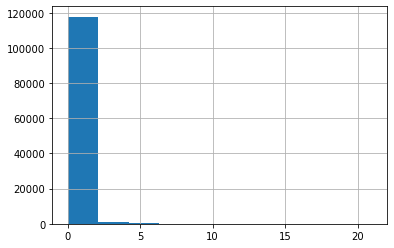

In [86]:
hotel['booking_changes'].hist()

In [87]:
hotel['booking_changes'].value_counts()

0     101314
1      12701
2       3805
3        927
4        376
5        118
6         63
7         31
8         17
9          8
10         6
13         5
14         5
15         3
11         2
12         2
16         2
17         2
20         1
18         1
21         1
Name: booking_changes, dtype: int64

In [88]:
print(hotel.loc[hotel['booking_changes'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['booking_changes'] == 0, 'is_canceled'].value_counts())

0    15243
1     2833
Name: is_canceled, dtype: int64
0    59923
1    41391
Name: is_canceled, dtype: int64


- 예약변경을 한 번도 하지 않은 사람들 중에서 예약 취소 여부 비율은 비슷했다.
- 예약변경을 한번 이상한 사람들 중에서는 예약 취소하지 않는 비율이 많았다.
- 따라서, 예약변경을 그래도 많이할수록 예약을 취소하지 않는다.
- 그러므로 이상치를 제거하는 것보다 이상치에 민감하지 않은 Robust scaler를 사용해야 할 듯 하다.

### days_in_waiting_list

<AxesSubplot:>

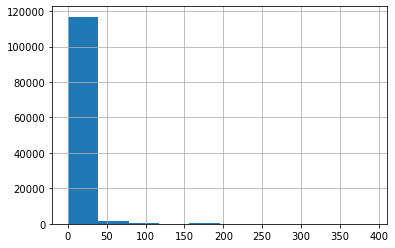

In [89]:
hotel['days_in_waiting_list'].hist()

In [90]:
hotel['days_in_waiting_list'].value_counts()

0      115692
39        227
58        164
44        141
31        127
35         96
46         94
69         89
63         83
50         80
87         80
38         76
111        71
45         65
101        65
77         63
41         63
223        61
62         60
3          59
98         59
22         56
122        55
15         54
48         52
176        50
91         50
28         50
17         47
96         46
187        45
56         45
391        45
68         42
60         41
75         40
93         40
21         37
236        35
65         35
147        30
33         30
19         30
162        30
178        30
42         30
20         29
10         28
40         28
27         26
34         26
120        25
4          25
57         25
160        25
25         25
80         24
47         24
215        21
79         20
108        20
24         19
99         19
32         19
43         19
174        19
70         18
61         18
49         18
9          16
125        16
6     

In [91]:
# 예약이 확정될 때까지 하루이상걸린 예약건수들의 취소 여부비율 살펴보기
print(hotel.loc[hotel['days_in_waiting_list'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['days_in_waiting_list'] == 0, 'is_canceled'].value_counts())

1    2359
0    1339
Name: is_canceled, dtype: int64
0    73827
1    41865
Name: is_canceled, dtype: int64


- 예약을 확정짓는데 하루 이상 걸린 사람들은 예약취소하는 경향이 있는 듯하다.
- 이상치를 제거하지 않고 Robust scaler사용

### required_car_parking_spaces

<AxesSubplot:>

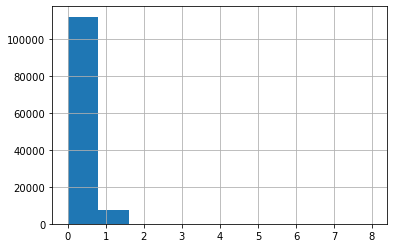

In [92]:
hotel['required_car_parking_spaces'].hist()

In [93]:
hotel['required_car_parking_spaces'].value_counts()

0    111974
1      7383
2        28
3         3
8         2
Name: required_car_parking_spaces, dtype: int64

In [94]:
# 주차공간을 요구하는 사람들은 예약을 취소할까?
print(hotel.loc[hotel['required_car_parking_spaces'] > 0, 'is_canceled'].value_counts())
print(hotel.loc[hotel['required_car_parking_spaces'] == 0, 'is_canceled'].value_counts())

0    7416
Name: is_canceled, dtype: int64
0    67750
1    44224
Name: is_canceled, dtype: int64


- 주차공간을 요구한 사람들은 무조건 예약을 취소하지 않는다.
- 따라서 이상치를 제거하지 않고 Robust Scaler적용

### total_of_special_requests

<AxesSubplot:>

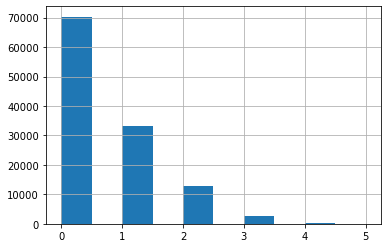

In [95]:
hotel['total_of_special_requests'].hist()

In [96]:
hotel['total_of_special_requests'].value_counts()

0    70318
1    33226
2    12969
3     2497
4      340
5       40
Name: total_of_special_requests, dtype: int64

In [97]:
# 이상치로 판단되는 4,5 일때 예약취소여부를 살펴보자
print(hotel.loc[hotel['total_of_special_requests'] > 3, 'is_canceled'].value_counts())
print(hotel.loc[hotel['total_of_special_requests'] == 3, 'is_canceled'].value_counts())

0    342
1     38
Name: is_canceled, dtype: int64
0    2051
1     446
Name: is_canceled, dtype: int64


- 호텔에 특별요구(방 종류 변경, 고층실 예약 요구)를 많이 한사람들은 예약을 취소하지 않는 경향이 강하다
- 따라서 이상치를 제거하지 않고 Robust scaler적용

## Feature Engineering 

* Target variable(binary) : is_canceled
* Numeric variables 
    - 예약날짜 관련 함수는 모두 삭제
    - lead_time : log1p변환
    - 어른,아이,아기 변수 삭제
    - is_repeated_guest는 현재상태 유지(레이블 인코딩)

In [98]:
# 결측치가 존재하는 변수들 삭제
hotel = hotel.drop(['agent','company','country'], axis=1)
hotel['children'] = hotel['children'].fillna(0)
hotel.isnull().sum().sum()

0

In [102]:
category_cols = ['hotel','meal','market_segment','distribution_channel','reserved_room_type',
                 'assigned_room_type','deposit_type','customer_type']
numeric_cols = ['lead_time','stays_in_weekend_nights','stays_in_week_nights','adults','children','babies',
               'is_repeated_guest','previous_cancellations','previous_bookings_not_canceled',
               'booking_changes','days_in_waiting_list','required_car_parking_spaces','total_of_special_requests']
categorical_df = hotel[category_cols]
numeric_df = hotel[numeric_cols]
print(categorical_df.shape)
print(numeric_df.shape)

(119390, 8)
(119390, 13)


### Categorical Variable encoding

In [103]:
# 이진분류 문제이기 때문에 범주형 변수들을 원-핫 인코딩보다는 레이블 인코딩으로 변환
# 회귀분석 문제일 때는 범주형 변수를 레이블 인코딩으로 하면 레이블 간의 순서 차이값들이 예측값에 영향미침 -> 그렇다면 로지스틱회귀분석을 사용하면 안되지 않을까?
from sklearn.preprocessing import LabelEncoder

category_columns = categorical_df.columns.tolist()
encoders = {}

for col in category_columns:
    encoder = LabelEncoder()
    categorical_df[col] = encoder.fit_transform(categorical_df[col])
    encoders[col] = encoder

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [104]:
categorical_df.head()

,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type
0,1,0,3,1,2,2,0,2
1,1,0,3,1,2,2,0,2
2,1,0,3,1,0,2,0,2
3,1,0,2,0,0,0,0,2
4,1,0,6,3,0,0,0,2


### Numeric Variable encoding

In [105]:
# lead_time에 로그 취해주기
numeric_df['lead_time'] = np.log1p(numeric_df['lead_time'])

/Users/younghun/opt/anaconda3/envs/venvforpython/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [107]:
# is_canceled(종속변수)와 lead_time변수 제외하고 모두 Robust Scaler 적용
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
numeric_df.iloc[:,1:] = scaler.fit_transform(numeric_df.iloc[:,1:])
numeric_df.head()

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
0,5.837730,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0
1,6.603944,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0
2,2.079442,-0.5,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2.639057,-0.5,-0.5,-1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.708050,-0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


### merge categorical and numeric variables

In [108]:
print("범주형 변수 데이터프레임:", categorical_df.shape)
print("수치형 변수 데이터프레임:", numeric_df.shape)

범주형 변수 데이터프레임: (119390, 8)
수치형 변수 데이터프레임: (119390, 13)


In [110]:
final_data = pd.concat([categorical_df, numeric_df], axis=1)
final_data['is_canceled'] = hotel['is_canceled']
final_data.head(3)

,hotel,meal,market_segment,distribution_channel,reserved_room_type,assigned_room_type,deposit_type,customer_type,lead_time,stays_in_weekend_nights,...,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
0,1,0,3,1,2,2,0,2,5.837730,-0.5,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0
1,1,0,3,1,2,2,0,2,6.603944,-0.5,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0
2,1,0,3,1,0,2,0,2,2.079442,-0.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [112]:
##### 밑에서부터 모델링 코드 재정비

## Modeling

- 많은 범주형 변수의 레이블 인코딩으로 회귀식을 가정한 머신러닝 모델 사용은 지양
- 이진분류 문제
    * Logisitc Regression
    * SVM
    * Ensemble
    * ANN

### split train, validation and test data
- 보통 3가지 종류의 비율로 나눔
    * 1. train : val : test = 70 : 15 : 15
    * 2. train : val : test = 80 : 10 : 10
    * 3. train : val : test = 60 : 20 : 20
    
- 모델을 최종 선정하고 위 3가지 분할 방법을 각각 사용해본 후 가장 최고의 성능을 내는 데이터 분할 비율을 선택

In [50]:
# 우선 최종 모델을 선정해야 하므로 데이터 split 방법 중 1번을 선택해서 진행
from sklearn.model_selection import train_test_split

# 독립변수(feature), 종속변수(target) 분할
feature = final_data.drop(['is_canceled'], axis=1) # df로반환
target = final_data['is_canceled'] # array로 반환

# Train : Validation = 7 : 3 비율로 분할
X_train, X_val_test, y_train, y_val_test = train_test_split(feature, target, test_size=0.3, random_state=42)
print("Train shape:", X_train.shape)
print("Train의 target label분포도:\n", y_train.value_counts())
print()
print("Validation shape:", X_val_test.shape)
print("Validation의 target label분포도:\n", y_val_test.value_counts())

Train shape: (83573, 19)
Train의 target label분포도:
 0    52688
1    30885
Name: is_canceled, dtype: int64

Validation shape: (35817, 19)
Validation의 target label분포도:
 0    22478
1    13339
Name: is_canceled, dtype: int64


In [51]:
# Validataion 데이터의 절반을 Test 데이터로 분할해서 총 데이터비율을 Train : Val : Test = 70 : 15 : 15로 맞춰주기
# 맞춰줄 때 label분포도 확인하면서 분할하기
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)
print("Validation Shape:", X_val.shape)
print("Validataion target label분포:\n", y_val.value_counts())
print()
print("Test Shape:", X_test.shape)
print("Test target label분포:\n", y_test.value_counts())

Validation Shape: (17908, 19)
Validataion target label분포:
 0    11204
1     6704
Name: is_canceled, dtype: int64

Test Shape: (17909, 19)
Test target label분포:
 0    11274
1     6635
Name: is_canceled, dtype: int64


In [52]:
# 데이터 분할 비율 잘 맞췄는지 확인해보기
total_num = final_data.shape[0]
print(f"Train : {X_train.shape[0]/total_num}, Validation : {X_val.shape[0]/total_num},Test : {X_test.shape[0]/total_num}")

Train : 0.7, Validation : 0.14999581204455983,Test : 0.15000418795544015


In [53]:
# 교차검증을 해야하므로 분할한 3가지 중 Train과 Validation 합친 후 클래스불균형 여부 확인
train_val_feature = pd.concat([X_train, X_val], axis=0)
train_val_target = pd.concat([y_train, y_val], axis=0)

print("Train, Val합친 데이터 클래스 분포 확인\n", train_val_target.value_counts())

Train, Val합친 데이터 클래스 분포 확인
 0    63892
1    37589
Name: is_canceled, dtype: int64


- Train, Validation, Test 데이터 레이블 분포가 모두 두배 차이가 난다.
- 이진 분류이기 때문에 오버샘플링, 다운샘플링 방법보다는 모델 성능 평가시 Confusion Matrix 지표를 활용해야 할 듯!

- **주어진 문제 상황에서, 실제로는 예약취소(Positive=1)를 했는데, 모델이 '예약을 취소했어' 즉, Positive라고 예측하는 지표가 더욱 중요하다. 따라서 ``재현율의 값이 중요!``**
- 즉, 모델이 '예약을 취소했어(Positive)'라고 예측을 했는데, 실제 예약은 '취소하지 않았을 때(Negative)' 발생할 위험성은 다소 적다. 왜냐하면 예약 취소했을 거라고 예측했지만 실제로 예약취소를 하지 않은 고객에게 추가적인 마케팅을 했더라도 별다른 위험성이 발생되지 않기 때문이다.

### Logisitic Regression

In [55]:
# Confusion Matrix 평가지표 얻는 함수 정의
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
# 3개의 지표를 반환
def get_score(y, y_, y_proba):
    accuracy = accuracy_score(y, y_)
    precision = precision_score(y, y_)
    recall = recall_score(y, y_)
    auc = roc_auc_score(y, y_proba)
    return accuracy, precision, recall, auc

In [78]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# 원본 데이터를 기준으로 70 : 15를 맞춰야하기 때문에 
# Train과 Validation을 합친 데이터를 다시 Train, Validation으로 나눌 때 대략적인 값인 8:2정도의 비율로 나누자
# 정확한 비율은 21.43%를 Validation 데이터로 해야하지만 20%정도로 맞추기
X_train, X_val, y_train, y_val = train_test_split(train_val_feature, train_val_target,
                                                 test_size=0.2)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
y_pred = lr_clf.predict(X_val)
accuracy, precision, recall = get_score(y_val, y_pred)
print(f"정확도:{accuracy:.4f}\n정밀도:{precision:.4f}\n재현율:{recall:.4f}")

정확도:0.8024
정밀도:0.8505
재현율:0.5729


### SVM(Support Vector Machine)

In [79]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(train_val_feature, train_val_target,
                                                 test_size=0.2)
svc = SVC(kernel='rbf', C=1, gamma='scale')
svc.fit(X_train, y_train)
y_pred = svc.predict(X_val)
accuracy, precision, recall = get_score(y_val, y_pred)
print(f"정확도:{accuracy:.4f}\n정밀도:{precision:.4f}\n재현율:{recall:.4f}")

정확도:0.7697
정밀도:0.9652
재현율:0.3986


- 하이퍼파라미터 튜닝을 해도 재현율이 많이 올라갈 것 같진 않다..

### Ensemble
- Voting
- RandomForest
- Light GBM
- GBM
- XGBoost
- Stacking

#### Voting

In [82]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#개별 모델 정의
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier()
svm_clf = SVC(probability=True)

# Voting 분류기에 결합시키기
voting_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf),('SVM',svm_clf)],
                             voting='soft')
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(train_val_feature, train_val_target,
                                                 test_size=0.2)
# Voting 분류기 학습
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_val)
accuracy, precision, recall = get_score(y_val, y_pred)
print(f"정확도:{accuracy:.4f}\n정밀도:{precision:.4f}\n재현율:{recall:.4f}")

정확도:0.8222
정밀도:0.8514
재현율:0.6305


#### Random Forest

In [89]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_val, y_train, y_val = train_test_split(train_val_feature, train_val_target,
                                                 test_size=0.2)
rf_clf = RandomForestClassifier(n_estimators=100, criterion='entropy',
                               min_samples_split=10, n_jobs=-1)
rf_clf.fit(X_train, y_train)
y_pred = rf_clf.predict(X_val)
accuracy, precision, recall = get_score(y_val, y_pred)
print(f"정확도:{accuracy:.4f}\n정밀도:{precision:.4f}\n재현율:{recall:.4f}")

정확도:0.8381
정밀도:0.8145
재현율:0.7229


#### XGBoost

In [67]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
# XGBoost는 검증 데이터 리스트안에 튜플형태로 입력해주면 내재적으로 교차검증 해줌 & GPU지원
val_set = [(X_val, y_val)]
xgb = XGBClassifier(n_estimators=300, learning_rate=0.1, random_state=42)
# XGBoost 학습시에 검증 데이터셋 넣어주기, 검증하면서 평가할 metric 종류도 넣어주기
xgb.fit(X_train, y_train, early_stopping_rounds=200, eval_set=val_set,
       eval_metric=['error','auc','map'])
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)[:,1]
auc = roc_auc_score(y_test, y_pred_proba)
accuracy, precision, recall = get_score(y_test, y_pred)
print(f"정확도:{accuracy:.4f}\n정밀도:{precision:.4f}\n재현율:{recall:.4f}")
print(f"AUC:{auc:.4f}")

[0]	validation_0-error:0.23537	validation_0-auc:0.746638	validation_0-map:0.7191
Multiple eval metrics have been passed: 'validation_0-map' will be used for early stopping.

Will train until validation_0-map hasn't improved in 200 rounds.
[1]	validation_0-error:0.23537	validation_0-auc:0.823462	validation_0-map:0.800181
[2]	validation_0-error:0.235537	validation_0-auc:0.828816	validation_0-map:0.806644
[3]	validation_0-error:0.235705	validation_0-auc:0.831562	validation_0-map:0.808445
[4]	validation_0-error:0.236375	validation_0-auc:0.837248	validation_0-map:0.814181
[5]	validation_0-error:0.235314	validation_0-auc:0.838231	validation_0-map:0.815061
[6]	validation_0-error:0.235537	validation_0-auc:0.837489	validation_0-map:0.813558
[7]	validation_0-error:0.235481	validation_0-auc:0.841867	validation_0-map:0.817094
[8]	validation_0-error:0.235537	validation_0-auc:0.846388	validation_0-map:0.819178
[9]	validation_0-error:0.235537	validation_0-auc:0.847003	validation_0-map:0.819885
[10]	v

[96]	validation_0-error:0.183717	validation_0-auc:0.884774	validation_0-map:0.856383
[97]	validation_0-error:0.183661	validation_0-auc:0.885194	validation_0-map:0.856652
[98]	validation_0-error:0.182488	validation_0-auc:0.886115	validation_0-map:0.857462
[99]	validation_0-error:0.183047	validation_0-auc:0.886153	validation_0-map:0.857479
[100]	validation_0-error:0.182656	validation_0-auc:0.88632	validation_0-map:0.857678
[101]	validation_0-error:0.182656	validation_0-auc:0.886373	validation_0-map:0.857731
[102]	validation_0-error:0.182097	validation_0-auc:0.88657	validation_0-map:0.857894
[103]	validation_0-error:0.182432	validation_0-auc:0.886921	validation_0-map:0.858166
[104]	validation_0-error:0.182432	validation_0-auc:0.886933	validation_0-map:0.858165
[105]	validation_0-error:0.182544	validation_0-auc:0.887014	validation_0-map:0.8583
[106]	validation_0-error:0.182432	validation_0-auc:0.887071	validation_0-map:0.858391
[107]	validation_0-error:0.182265	validation_0-auc:0.887178	va

[192]	validation_0-error:0.178579	validation_0-auc:0.892703	validation_0-map:0.864039
[193]	validation_0-error:0.178579	validation_0-auc:0.892734	validation_0-map:0.86409
[194]	validation_0-error:0.178468	validation_0-auc:0.892762	validation_0-map:0.864111
[195]	validation_0-error:0.178524	validation_0-auc:0.892766	validation_0-map:0.864106
[196]	validation_0-error:0.178468	validation_0-auc:0.892847	validation_0-map:0.864154
[197]	validation_0-error:0.178468	validation_0-auc:0.892855	validation_0-map:0.864186
[198]	validation_0-error:0.178524	validation_0-auc:0.892846	validation_0-map:0.864181
[199]	validation_0-error:0.178524	validation_0-auc:0.892847	validation_0-map:0.864185
[200]	validation_0-error:0.178524	validation_0-auc:0.892898	validation_0-map:0.864217
[201]	validation_0-error:0.178524	validation_0-auc:0.892902	validation_0-map:0.864236
[202]	validation_0-error:0.178524	validation_0-auc:0.892905	validation_0-map:0.864242
[203]	validation_0-error:0.178468	validation_0-auc:0.89

[288]	validation_0-error:0.176402	validation_0-auc:0.895544	validation_0-map:0.86703
[289]	validation_0-error:0.17629	validation_0-auc:0.895537	validation_0-map:0.867035
[290]	validation_0-error:0.17629	validation_0-auc:0.895564	validation_0-map:0.86708
[291]	validation_0-error:0.176513	validation_0-auc:0.895615	validation_0-map:0.867109
[292]	validation_0-error:0.176625	validation_0-auc:0.895644	validation_0-map:0.867171
[293]	validation_0-error:0.176625	validation_0-auc:0.895645	validation_0-map:0.867174
[294]	validation_0-error:0.176457	validation_0-auc:0.895636	validation_0-map:0.867142
[295]	validation_0-error:0.176457	validation_0-auc:0.895636	validation_0-map:0.867178
[296]	validation_0-error:0.176457	validation_0-auc:0.895633	validation_0-map:0.86717
[297]	validation_0-error:0.17629	validation_0-auc:0.895634	validation_0-map:0.867173
[298]	validation_0-error:0.17629	validation_0-auc:0.895673	validation_0-map:0.867185
[299]	validation_0-error:0.17629	validation_0-auc:0.895747	va

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

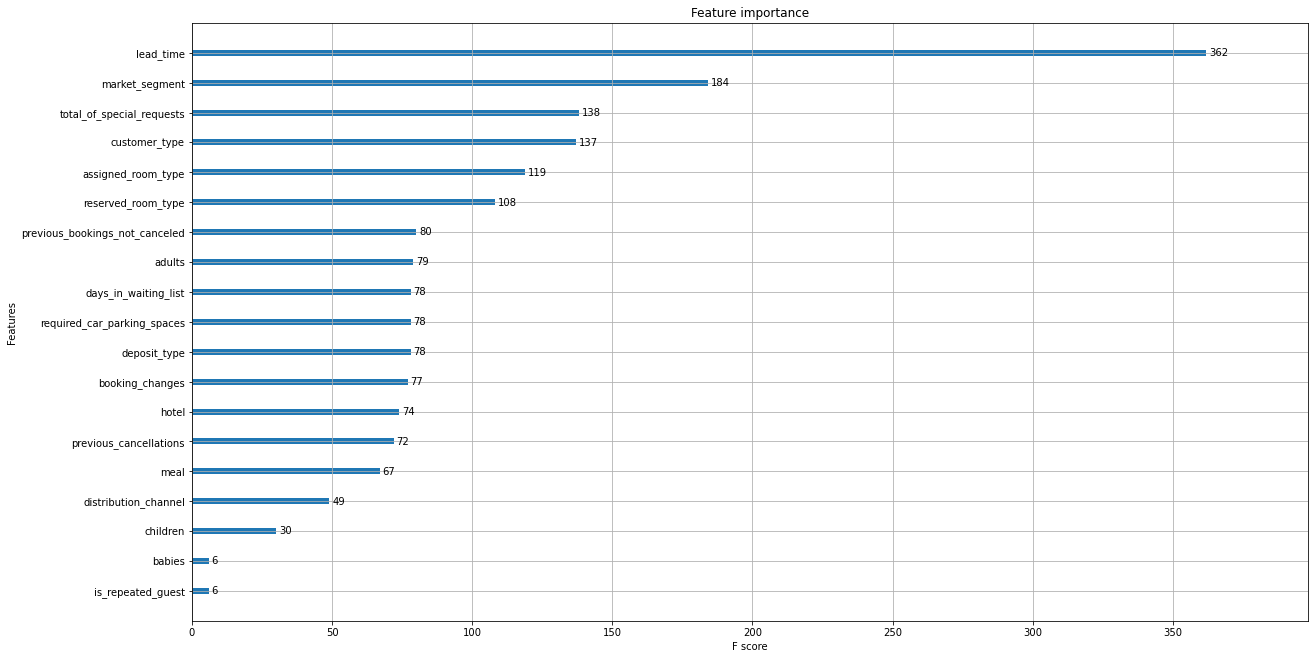

In [66]:
# XGBoost의 feature importance plot하기
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,11))
plot_importance(xgb, ax)

- 현재까지 RandomForest가 가장 괜찮은 성능(``재현율 기준으로``) 하지만 교차검증해보진 않은 상태
- XGBoost, LightGBM은 교차검증 후 Test데이터에도 적용함

#### LightGBM

In [72]:
from lightgbm import LGBMClassifier

val_set = [(X_val, y_val)]
lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.1,
                     random_state=42)
lgbm.fit(X_train, y_train, early_stopping_rounds=250,
         eval_set=val_set,
         eval_metric='auc')
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:,1]
acc, pre, rec, auc = get_score(y_test, y_pred, y_pred_proba)
print(f"정확도:{acc:.4f}\n정밀도:{pre:.4f}\n재현율:{rec:.4f}\nAUC:{auc:.4f}")

[1]	valid_0's auc: 0.86988	valid_0's binary_logloss: 0.619607
Training until validation scores don't improve for 250 rounds
[2]	valid_0's auc: 0.871913	valid_0's binary_logloss: 0.58667
[3]	valid_0's auc: 0.873743	valid_0's binary_logloss: 0.559557
[4]	valid_0's auc: 0.874563	valid_0's binary_logloss: 0.537148
[5]	valid_0's auc: 0.876626	valid_0's binary_logloss: 0.518268
[6]	valid_0's auc: 0.877788	valid_0's binary_logloss: 0.502435
[7]	valid_0's auc: 0.87777	valid_0's binary_logloss: 0.488909
[8]	valid_0's auc: 0.879289	valid_0's binary_logloss: 0.476666
[9]	valid_0's auc: 0.880187	valid_0's binary_logloss: 0.466167
[10]	valid_0's auc: 0.880818	valid_0's binary_logloss: 0.457038
[11]	valid_0's auc: 0.881927	valid_0's binary_logloss: 0.44876
[12]	valid_0's auc: 0.883012	valid_0's binary_logloss: 0.441312
[13]	valid_0's auc: 0.883437	valid_0's binary_logloss: 0.434906
[14]	valid_0's auc: 0.883984	valid_0's binary_logloss: 0.429467
[15]	valid_0's auc: 0.884602	valid_0's binary_logloss: 

[143]	valid_0's auc: 0.905347	valid_0's binary_logloss: 0.358225
[144]	valid_0's auc: 0.905447	valid_0's binary_logloss: 0.358079
[145]	valid_0's auc: 0.905498	valid_0's binary_logloss: 0.358018
[146]	valid_0's auc: 0.905537	valid_0's binary_logloss: 0.35786
[147]	valid_0's auc: 0.905581	valid_0's binary_logloss: 0.357777
[148]	valid_0's auc: 0.905578	valid_0's binary_logloss: 0.357781
[149]	valid_0's auc: 0.905608	valid_0's binary_logloss: 0.357719
[150]	valid_0's auc: 0.905707	valid_0's binary_logloss: 0.357571
[151]	valid_0's auc: 0.905845	valid_0's binary_logloss: 0.357358
[152]	valid_0's auc: 0.905856	valid_0's binary_logloss: 0.357343
[153]	valid_0's auc: 0.905923	valid_0's binary_logloss: 0.357227
[154]	valid_0's auc: 0.905905	valid_0's binary_logloss: 0.357217
[155]	valid_0's auc: 0.905942	valid_0's binary_logloss: 0.35714
[156]	valid_0's auc: 0.906092	valid_0's binary_logloss: 0.356897
[157]	valid_0's auc: 0.906149	valid_0's binary_logloss: 0.356792
[158]	valid_0's auc: 0.9061

[293]	valid_0's auc: 0.909024	valid_0's binary_logloss: 0.351326
[294]	valid_0's auc: 0.909065	valid_0's binary_logloss: 0.351278
[295]	valid_0's auc: 0.90908	valid_0's binary_logloss: 0.351267
[296]	valid_0's auc: 0.909073	valid_0's binary_logloss: 0.351247
[297]	valid_0's auc: 0.909131	valid_0's binary_logloss: 0.351168
[298]	valid_0's auc: 0.909124	valid_0's binary_logloss: 0.351177
[299]	valid_0's auc: 0.909113	valid_0's binary_logloss: 0.351179
[300]	valid_0's auc: 0.909107	valid_0's binary_logloss: 0.351216
[301]	valid_0's auc: 0.909148	valid_0's binary_logloss: 0.351143
[302]	valid_0's auc: 0.909174	valid_0's binary_logloss: 0.351092
[303]	valid_0's auc: 0.909202	valid_0's binary_logloss: 0.351018
[304]	valid_0's auc: 0.909214	valid_0's binary_logloss: 0.350989
[305]	valid_0's auc: 0.909216	valid_0's binary_logloss: 0.350993
[306]	valid_0's auc: 0.909228	valid_0's binary_logloss: 0.350961
[307]	valid_0's auc: 0.909226	valid_0's binary_logloss: 0.350963
[308]	valid_0's auc: 0.909

- LightGBM이 XGBoost보다 Test데이터에 더 높은 재현율을 보임!

#### MLPClassifier

In [76]:
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier()
mlp_clf.fit(X_train, y_train)
y_pred = mlp_clf.predict(X_val)
y_pred_proba = mlp_clf.predict_proba(X_val)[:,1]

acc, pre, rec, auc = get_score(y_val, y_pred, y_pred_proba)
print(f"정확도:{acc:.4f}\n정밀도:{pre:.4f}\n재현율:{rec:.4f}\nAUC:{auc:.4f}")

정확도:0.8284
정밀도:0.8125
재현율:0.7041
AUC:0.8991


### 최종모델 선정

- 최종모델 2가지
    * Test데이터 검정까지한 LightGBM
    * Validation 데이터로 1번 검정까지한 RandomForest
    
- 두 모델 중 최종모델을 선정하자

In [94]:
# RandomForest로 교차검증 후 Test데이터로 성능평가
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

rf_clf = RandomForestClassifier(n_estimators=200, criterion='entropy',
                               min_samples_split=10, n_jobs=-1, random_state=42)
scores = ['accuracy','precision','recall']
for score in scores:
    model_score = cross_val_score(rf_clf, train_val_feature,
                       train_val_target, scoring=score, cv=3)
    avg_score = np.mean(model_score)
    print(f"{score} score : {avg_score :.4f}")

accuracy score : 0.8316
precision score : 0.8110
recall score : 0.7112


In [97]:
#LightGBM으로 Test data 예측후 성능 평가
from lightgbm import LGBMClassifier

lgbm = LGBMClassifier(n_estimators=400, learning_rate=0.1,
                     random_state=42)
lgbm.fit(train_val_feature, train_val_target)
y_pred = lgbm.predict(X_test)
y_pred_proba = lgbm.predict_proba(X_test)[:,1]
acc, pre, rec, auc = get_score(y_test, y_pred, y_pred_proba)
print(f"정확도:{acc:.4f}\n정밀도:{pre:.4f}\n재현율:{rec:.4f}\nAUC:{auc:.4f}")

정확도:0.8385
정밀도:0.8389
재현율:0.6980
AUC:0.9099


In [57]:
# Test 데이터에 예측하고 metric 얻기
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=200, criterion='entropy',
                               min_samples_split=10, n_jobs=-1, random_state=42)
rf_clf.fit(train_val_feature, train_val_target)

# Test데이터에 대한 예측
y_pred = rf_clf.predict(X_test)
y_pred_proba = rf_clf.predict_proba(X_test)[:,1]
# metric 출력
acc, pre, rec, auc = get_score(y_test, y_pred, y_pred_proba)
print('*'*7,'Test 데이터로 평가 후 성능','*'*7)
print(f"정확도:{acc:.4f}\n정밀도:{pre:.4f}\n재현율:{rec:.4f}\nAUC:{auc:.4f}")

******* Test 데이터로 평가 후 성능 *******
정확도:0.8362
정밀도:0.8182
재현율:0.7171
AUC:0.9084


- RandomForest가 가장 좋은 성능을 보였다. 따라서 최종 모델은 **``Random Forest``**로 선정!

### GridSearchCV로 하이파라미터 튜닝하기

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_auc_score
# 4개의 지표를 반환
def get_score(y, y_, y_proba):
    accuracy = accuracy_score(y, y_)
    precision = precision_score(y, y_)
    recall = recall_score(y, y_)
    auc = roc_auc_score(y, y_proba)
    return accuracy, precision, recall, auc

params = {'n_estimators':[200, 500, 1000],
         'min_samples_split':[5, 10]}

rf_clf = RandomForestClassifier(criterion='entropy', n_jobs=-1,
                               random_state=44)
grid_rf = GridSearchCV(rf_clf, param_grid=params, cv=5,
                      n_jobs=-1)

grid_rf.fit(train_val_feature, train_val_target)
y_pred = grid_rf.predict(X_test)
y_pred_proba = grid_rf.predict_proba(X_test)[:,1]
acc, pre, rec, auc = get_score(y_test, y_pred, y_pred_proba)
print(f"정확도: {acc:.4f}\n정밀도: {pre:.4f}\n재현율: {rec:.4f}\nAUC: {auc:.4f}")

정확도: 0.8362
정밀도: 0.8194
재현율: 0.7154
AUC: 0.9085


In [80]:
best_rf = grid_rf.best_estimator_

In [89]:
feature_df = pd.DataFrame(data=best_rf.feature_importances_, index=feature.columns, columns=['importance'])
feature_df = feature_df.sort_values(by='importance', ascending=False)
feature_df.head()

,importance
lead_time,0.322094
deposit_type,0.195507
market_segment,0.071211
total_of_special_requests,0.070531
previous_cancellations,0.056940


<AxesSubplot:xlabel='importance'>

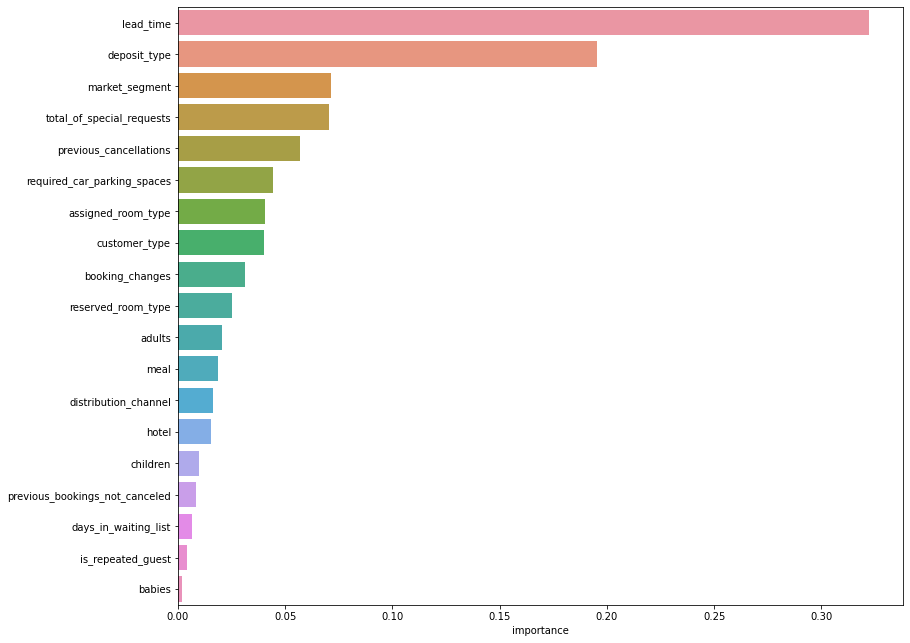

In [90]:
import seaborn as sns
plt.figure(figsize=(13,11))
sns.barplot(x=feature_df['importance'], y=feature_df.index)

## 예약취소 여부 예측 최종 모델

- Ensemble의 Random Forest 모형 선정
- 데이터 분할
    - Train : Validation : Test = 70 : 15 : 15 비율로 선정
    - GridSearchCV로 하이퍼파라미터 튜닝하면서 5번의 교차검증 실시
    
    
- 측정지표
    * 정확도 : 83%
    * 정밀도 : 81%
    * 재현율 : 71%
    * AUC 점수 : 0.91
    * 문제성격 상 재현율에 초점을 맞춰야 하기 때문에 재현율이 가장 높게 나오면서 정밀도와 균형을 이루는 쪽으로 선정
    
    
- 가장 중요한 변수 3가지
    * lead_time(예약을 최초로 한 시간부터 투숙하기 위해 실제 호텔에 도착한 시간까지 걸린 시간)
    * deposit_type(보증금 유형), market_segment(호텔 예약할 때 어떤 경로를 통해 예약했는지)
        - 데이터 분석에서 도출해낸 결과처럼 deposit_type, 그다음은 market_segment 변수가 예약취소 여부에 어느정도 영향을 끼치는 변수로 작용
        - 예측모델링하기 전 설정한 가설들이 실제 결과와 일치하는 결과로 나타남